# Presence Pridiction

## Data Preparation

### Data Exploring

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from pandas.tseries.offsets import Week, WeekOfMonth, Day

Load the csv

In [2]:
data = pd.read_csv('personal_data.csv')

In [3]:
print(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609536 entries, 0 to 609535
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   IdPresenceDeclaration  609536 non-null  int64 
 1   OperatorCode           609536 non-null  object
 2   DeclarationDate        609536 non-null  object
 3   IdPresenceState        609536 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 18.6+ MB
None


,IdPresenceDeclaration,OperatorCode,DeclarationDate,IdPresenceState
0,1,10.00.12,2014-09-30 08:00:00,1
1,2,10.00.12,2014-09-30 12:00:00,2
2,3,10.00.12,2014-09-30 13:00:00,1
3,4,10.00.12,2014-09-30 17:00:00,2
4,257,10.00.12,2014-10-01 08:00:00,1


Dataset contains 609536 rows and 4 columns.

In [4]:
print(data.isnull().sum())


IdPresenceDeclaration    0
OperatorCode             0
DeclarationDate          0
IdPresenceState          0
dtype: int64


No null values.

In [5]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")


IdPresenceDeclaration: 609536 unique values
OperatorCode: 64 unique values
DeclarationDate: 9524 unique values
IdPresenceState: 2 unique values


We Have the presence data of 64 workers, with 609539 declartions, and With only 2 unique values, i assume this is a binary variable representing the state of presence 1 for present and 2 for absent. 

     Convert DeclarationDate to datetime

In [6]:

data['DeclarationDate'] = pd.to_datetime(data['DeclarationDate'])


print(data.head())


   IdPresenceDeclaration OperatorCode     DeclarationDate  IdPresenceState
0                      1     10.00.12 2014-09-30 08:00:00                1
1                      2     10.00.12 2014-09-30 12:00:00                2
2                      3     10.00.12 2014-09-30 13:00:00                1
3                      4     10.00.12 2014-09-30 17:00:00                2
4                    257     10.00.12 2014-10-01 08:00:00                1


In [ ]:
data['Hour'] = data['DeclarationDate'].dt.hour
data['Date'] = data['DeclarationDate'].dt.date

declarations_at_8 = data[(data['Hour'] == 8)]
declarations_at_17 = data[(data['Hour'] == 17)]


merged_declarations = pd.merge(
    declarations_at_8[['OperatorCode', 'Date']],
    declarations_at_17[['OperatorCode', 'Date']],
    on=['OperatorCode', 'Date'],
    how='left',
    indicator=True
)


both_present = merged_declarations[merged_declarations['_merge'] == 'both'].shape[0]
only_start_present = merged_declarations[merged_declarations['_merge'] == 'left_only'].shape[0]

print(f"Days with both declarations: {both_present}")
print(f"Days with only start declaration: {only_start_present}")
print(f"Percentage of days with both: {both_present / len(declarations_at_8) * 100:.2f}%")


Days with both declarations: 152384
Days with only start declaration: 0
Percentage of days with both: 100.00%


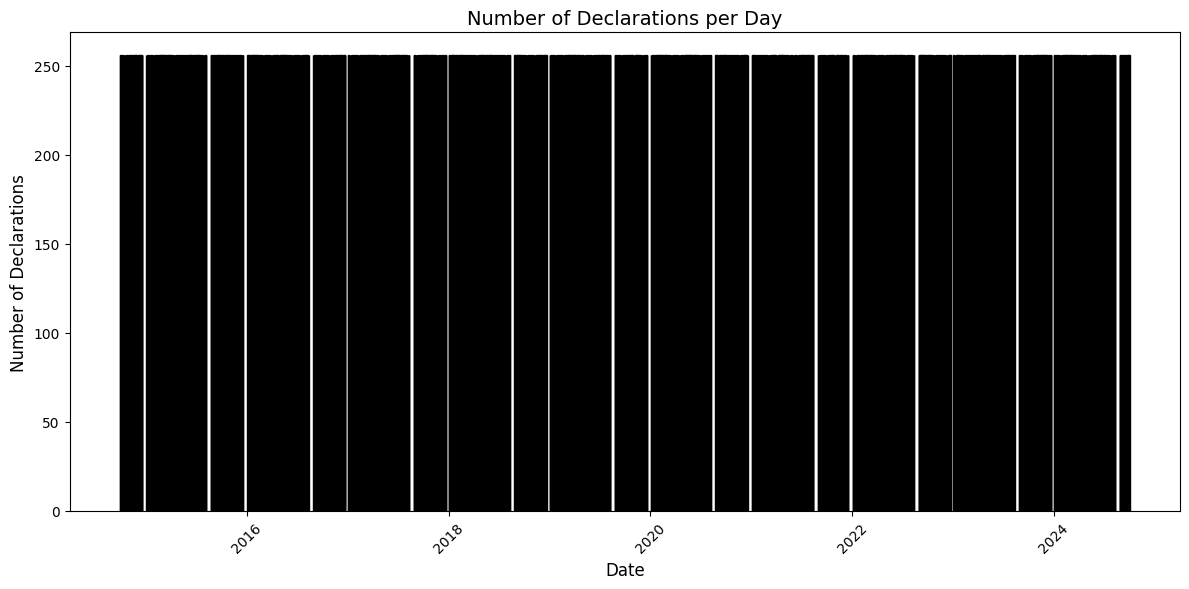

In [ ]:
unique_dates = data['Date'].unique()
unique_dates = sorted(unique_dates)  

# Create a DataFrame to count declarations for each date
date_counts = data['Date'].value_counts().sort_index()


plt.figure(figsize=(12, 6))
plt.bar(date_counts.index, date_counts.values, color='skyblue', edgecolor='black')
plt.title('Number of Declarations per Day', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Declarations', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


With this, we can assume that the data is continues, if there is a declaration on a particular day the worker is present, if there isnt the  worker is absent, we can simplify this by taking out the extra data which are the declarations past 8 am.

Also there seem to be some kind of global vacation

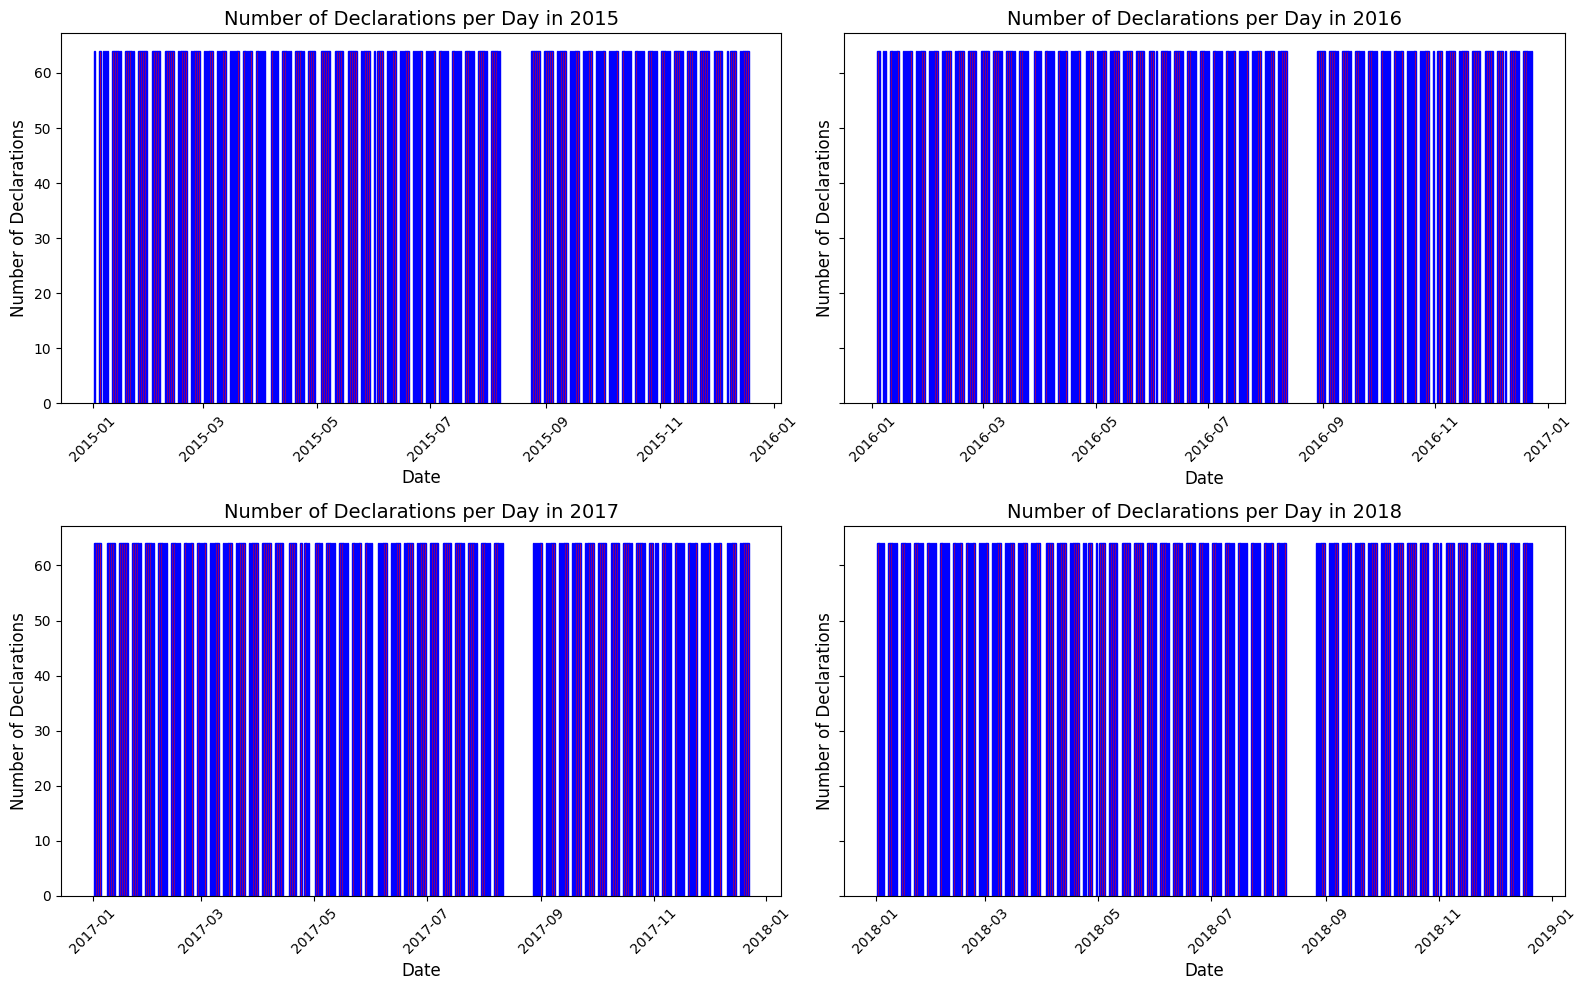

In [ ]:

data['Date'] = pd.to_datetime(data['Date'])

years = [2015, 2016, 2017, 2018]
data_filtered = data[data['Date'].dt.year.isin(years)]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=False, sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    year_data = data_filtered[data_filtered['Date'].dt.year == year]
    date_counts = (year_data['Date'].value_counts().sort_index()) / 4
    axes[i].bar(date_counts.index, date_counts.values, color='red', edgecolor='blue')
    axes[i].set_title(f'Number of Declarations per Day in {year}', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Number of Declarations', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()


So as we can see the company goes on a yearly vacation on the second friday of august and also on the third friday of December to the first monday of january

In [ ]:

data['Date'] = data['DeclarationDate'].dt.date
eight_am_declarations = data[data['DeclarationDate'].dt.hour == 8]
simplified_data = eight_am_declarations.drop_duplicates(subset=['OperatorCode', 'Date'], keep='first')
presence_per_day = simplified_data.groupby('Date')['OperatorCode'].nunique()


In [ ]:
print(simplified_data.head())

    IdPresenceDeclaration OperatorCode     DeclarationDate  IdPresenceState  \
0                       1     10.00.12 2014-09-30 08:00:00                1   
4                     257     10.00.12 2014-10-01 08:00:00                1   
8                     513     10.00.12 2014-10-02 08:00:00                1   
12                    769     10.00.12 2014-10-03 08:00:00                1   
16                   1025     10.00.12 2014-10-06 08:00:00                1   

    Hour        Date  
0      8  2014-09-30  
4      8  2014-10-01  
8      8  2014-10-02  
12     8  2014-10-03  
16     8  2014-10-06  


In [12]:
print(simplified_data.describe())

       IdPresenceDeclaration                DeclarationDate  IdPresenceState  \
count           152384.00000                         152384         152384.0   
mean            304767.00000  2019-09-29 07:33:23.359932928              1.0   
min                  1.00000            2014-09-30 08:00:00              1.0   
25%             152384.00000            2017-03-30 08:00:00              1.0   
50%             304767.00000            2019-09-27 08:00:00              1.0   
75%             457150.00000            2022-04-01 08:00:00              1.0   
max             609533.00000            2024-09-30 08:00:00              1.0   
std             175958.46419                            NaN              0.0   

           Hour  
count  152384.0  
mean        8.0  
min         8.0  
25%         8.0  
50%         8.0  
75%         8.0  
max         8.0  
std         0.0  


In [13]:
min_date = simplified_data['DeclarationDate'].min()
max_date = simplified_data['DeclarationDate'].max()

In [14]:
print(min_date)
print(max_date)

2014-09-30 08:00:00
2024-09-30 08:00:00


10 years of data

In [15]:
152384.00000  *4

609536.0

we can see that we simplifed the data by 4, we removed the "redundencies", 609536 is the number of all declarations, 4 is the number of declarations per day.

Moving on, i want to create absent/present dataset

But first i want to take vacations out of the data set, **Excluding these periods to ensure the model learns absence patterns based on operational days, unaffected by pre-determined vacations.**

In [ ]:

simplified_data['Date'] = pd.to_datetime(simplified_data['Date'])


def get_vacation_ranges(year):
    
    aug_start = pd.Timestamp(year=year, month=8, day=1) + pd.DateOffset(weekday=4, n=0)  
    aug_start = aug_start + pd.Timedelta(days=7)  
    aug_end = aug_start + pd.Timedelta(days=15)  
    
    
    dec_start = pd.Timestamp(year=year, month=12, day=1) + pd.DateOffset(weekday=4, n=0)  
    dec_start = dec_start + pd.Timedelta(days=14)  
    jan_first_monday = pd.Timestamp(year=year + 1, month=1, day=1) + pd.DateOffset(weekday=0)  
    
    
    print(f"Vacation for {year}: August {aug_start.date()} to {aug_end.date()}, December {dec_start.date()} to {jan_first_monday.date()}")
    
    return [(aug_start, aug_end), (dec_start, jan_first_monday)]


vacation_ranges = []
for year in simplified_data['Date'].dt.year.unique():
    vacation_ranges.extend(get_vacation_ranges(year))


exclude_mask = pd.Series(False, index=simplified_data.index)


print("Vacation Ranges: ", vacation_ranges)


for start, end in vacation_ranges:
    exclude_mask |= (simplified_data['Date'] >= start) & (simplified_data['Date'] < end)


print(f"Before exclusion: {simplified_data.shape[0]} rows")
simplified_data = simplified_data[~exclude_mask]
print(f"After exclusion: {simplified_data.shape[0]} rows")


print(f"Removed {exclude_mask.sum()} rows due to vacation periods.")


Vacation for 2014: August 2014-08-08 to 2014-08-23, December 2014-12-19 to 2015-01-05
Vacation for 2015: August 2015-08-14 to 2015-08-29, December 2015-12-18 to 2016-01-04
Vacation for 2016: August 2016-08-12 to 2016-08-27, December 2016-12-16 to 2017-01-02
Vacation for 2017: August 2017-08-11 to 2017-08-26, December 2017-12-15 to 2018-01-01
Vacation for 2018: August 2018-08-10 to 2018-08-25, December 2018-12-21 to 2019-01-07
Vacation for 2019: August 2019-08-09 to 2019-08-24, December 2019-12-20 to 2020-01-06
Vacation for 2020: August 2020-08-14 to 2020-08-29, December 2020-12-18 to 2021-01-04
Vacation for 2021: August 2021-08-13 to 2021-08-28, December 2021-12-17 to 2022-01-03
Vacation for 2022: August 2022-08-12 to 2022-08-27, December 2022-12-16 to 2023-01-02
Vacation for 2023: August 2023-08-11 to 2023-08-26, December 2023-12-15 to 2024-01-01
Vacation for 2024: August 2024-08-09 to 2024-08-24, December 2024-12-20 to 2025-01-06
Vacation Ranges:  [(Timestamp('2014-08-08 00:00:00'), 

Creating the Present/Absent Dataset

In [17]:
simplified_data.head(250)

,IdPresenceDeclaration,OperatorCode,DeclarationDate,IdPresenceState,Hour,Date
0,1,10.00.12,2014-09-30 08:00:00,1,8,2014-09-30
4,257,10.00.12,2014-10-01 08:00:00,1,8,2014-10-01
8,513,10.00.12,2014-10-02 08:00:00,1,8,2014-10-02
12,769,10.00.12,2014-10-03 08:00:00,1,8,2014-10-03
16,1025,10.00.12,2014-10-06 08:00:00,1,8,2014-10-06
...,...,...,...,...,...,...
1008,64513,10.00.12,2015-10-21 08:00:00,1,8,2015-10-21
1012,64769,10.00.12,2015-10-22 08:00:00,1,8,2015-10-22
1016,65025,10.00.12,2015-10-23 08:00:00,1,8,2015-10-23
1020,65281,10.00.12,2015-10-26 08:00:00,1,8,2015-10-26


In [ ]:

simplified_data['DeclarationDate'] = pd.to_datetime(simplified_data['DeclarationDate']).dt.date


result = []


for operator_code in simplified_data['OperatorCode'].unique():
    
    worker_data = simplified_data[simplified_data['OperatorCode'] == operator_code]
    
    
    start_date = worker_data['DeclarationDate'].min()
    end_date = worker_data['DeclarationDate'].max()
    
    
    all_days = pd.date_range(start=start_date, end=end_date, freq='B').date  
    
    
    presence = []
    
    for day in all_days:
        
        if day in worker_data['DeclarationDate'].values:
            
            presence.append(1)
        else:
            
            presence.append(0)
    
    
    for day, pres in zip(all_days, presence):
        result.append({'OperatorCode': operator_code, 'Date': day, 'Presence': pres})


result_df = pd.DataFrame(result)



In [ ]:

result_df['Date'] = pd.to_datetime(result_df['Date'])


exclude_mask = pd.Series(False, index=result_df.index)
for start, end in vacation_ranges:
    exclude_mask |= (result_df['Date'] >= start) & (result_df['Date'] < end)


result_df = result_df[~exclude_mask]


print(f"Removed {exclude_mask.sum()} rows from result_df due to vacation periods.")


Removed 14080 rows from result_df due to vacation periods.


In [ ]:

absent_days = result_df[result_df['Presence'] == 0].groupby('OperatorCode').size().reset_index(name='Absences')


print(absent_days)

   OperatorCode  Absences
0      10.00.12        63
1      10.00.15        63
2      10.00.19        63
3      10.00.20        63
4      10.00.24        63
..          ...       ...
59          COL        63
60         CURV        63
61          LON        63
62          MAG        63
63         PROD        63

[64 rows x 2 columns]


In [ ]:
first_worker_data = result_df[result_df['OperatorCode'] == result_df['OperatorCode'].iloc[0]]


absent_days_for_first_worker = first_worker_data[first_worker_data['Presence'] == 0]['Date'].tolist()


random_absent_days = random.sample(absent_days_for_first_worker, 5)

print("5 random absent days for the first worker:")
for day in random_absent_days:
    print(day)

5 random absent days for the first worker:
2022-06-02 00:00:00
2020-08-11 00:00:00
2021-12-08 00:00:00
2016-01-06 00:00:00
2016-03-28 00:00:00


With this we cleaned our data from vacation periods, now every worker has an absence of 93 days

Understading what we have

In [ ]:

result_df['Date'] = pd.to_datetime(result_df['Date'])


result_df['DayOfWeek'] = result_df['Date'].dt.day_name()


absences_df = result_df[result_df['Presence'] == 0]


In [24]:
result_df.head()

,OperatorCode,Date,Presence,DayOfWeek
0,10.00.12,2014-09-30,1,Tuesday
1,10.00.12,2014-10-01,1,Wednesday
2,10.00.12,2014-10-02,1,Thursday
3,10.00.12,2014-10-03,1,Friday
4,10.00.12,2014-10-06,1,Monday


In [25]:
len(absences_df)

4032

In [ ]:

absences_by_day_of_week = absences_df.groupby('DayOfWeek').size()


day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


absences_by_day_of_week = absences_by_day_of_week[day_order]


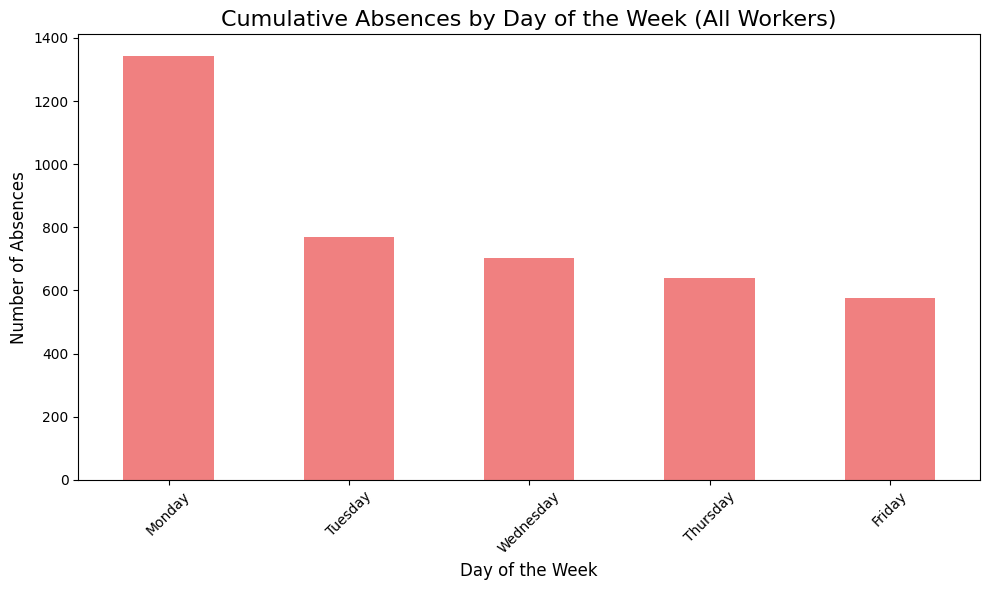

In [ ]:

plt.figure(figsize=(10, 6))
absences_by_day_of_week.plot(kind='bar', color='lightcoral')


plt.title('Cumulative Absences by Day of the Week (All Workers)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Absences', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

We can see the trend , the absence tend to be more twords the Start of the week

In [ ]:

absences_df['DayOfMonth'] = absences_df['Date'].dt.day

absences_by_day_of_month = absences_df.groupby('DayOfMonth').size()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7484\4247693132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absences_df['DayOfMonth'] = absences_df['Date'].dt.day


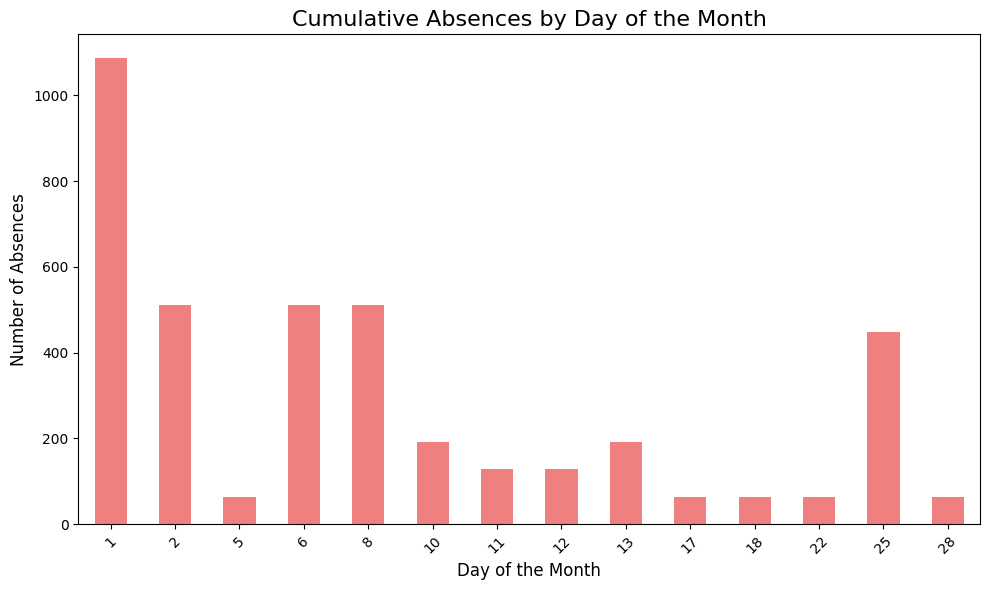

In [ ]:

plt.figure(figsize=(10, 6))
absences_by_day_of_month.plot(kind='bar', color='lightcoral')


plt.title('Cumulative Absences by Day of the Month', fontsize=16)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Absences', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

The day of the month can also be a good Feature to work with

In [ ]:

absences_df['WeekOfMonth'] = absences_df['Date'].apply(lambda x: (x.day - 1) // 7+1 )

absences_by_week_of_month = absences_df.groupby('WeekOfMonth').size()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7484\1012934570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absences_df['WeekOfMonth'] = absences_df['Date'].apply(lambda x: (x.day - 1) // 7+1 )


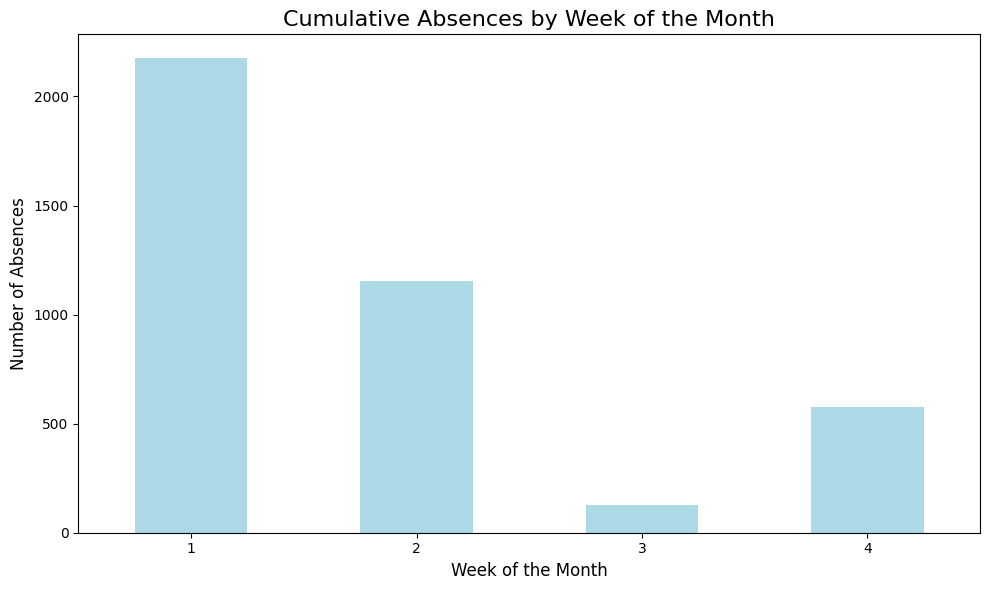

In [ ]:

plt.figure(figsize=(10, 6))
absences_by_week_of_month.plot(kind='bar', color='lightblue')


plt.title('Cumulative Absences by Week of the Month', fontsize=16)
plt.xlabel('Week of the Month', fontsize=12)
plt.ylabel('Number of Absences', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()


plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7484\456221551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absences_df['Month'] = absences_df['Date'].dt.month


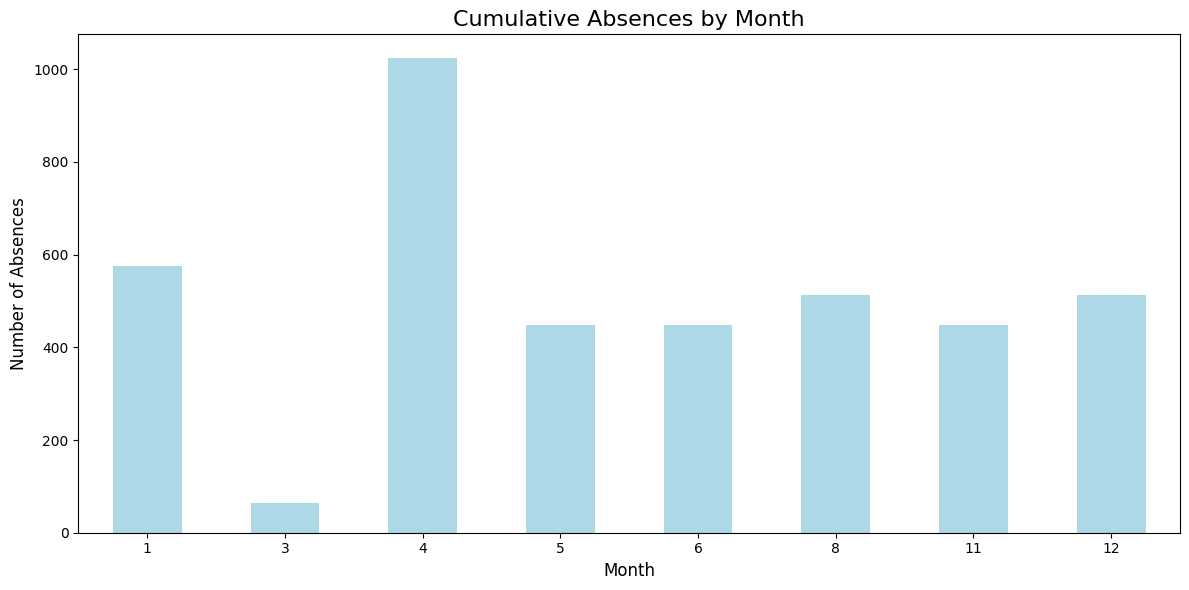

In [ ]:

absences_df['Month'] = absences_df['Date'].dt.month


absences_by_month = absences_df.groupby('Month').size()


plt.figure(figsize=(12, 6))
absences_by_month.plot(kind='bar', color='lightblue')


plt.title('Cumulative Absences by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Absences', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()


plt.show()


With this, we can see that from the date given we can get a probabilty wether an employee will absent or present.

The features we will be using are date, we will extract day of month and week, month, and week to make our prediction.

In [33]:
result_df.to_csv("Dataset.csv")

# Model training

In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np

In [111]:

result_df['DayOfWeek'] = result_df['Date'].dt.dayofweek


result_df['DayOfMonth'] = result_df['Date'].dt.day

result_df['WeekOfMonth'] = (np.ceil(result_df['DayOfMonth'] / 7)).astype(int)


result_df['Month'] = result_df['Date'].dt.month


features = ['DayOfWeek', 'DayOfMonth', 'WeekOfMonth', 'Month']
X = result_df[features]
y = result_df['Presence']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

model_xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgboost.fit(X_train, y_train)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [115]:
# Evaluate the model
y_pred = model_xgboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")


print(f"Model Accuracy: {accuracy * 100:.2f}%")


F1 Score: 1.00
Model Accuracy: 99.61%


In [116]:
y_pred = model_xgboost.predict(X_test)


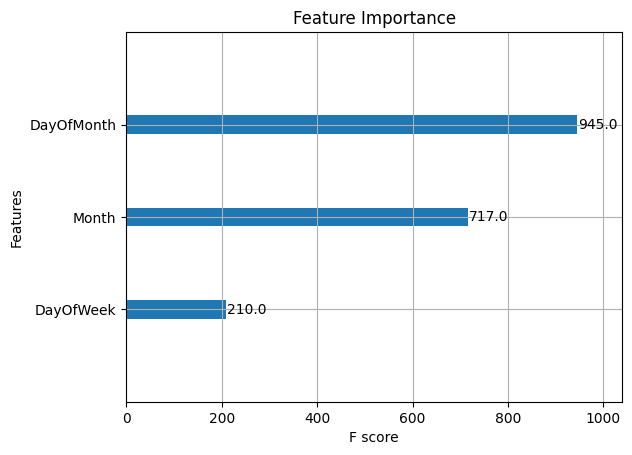

In [118]:
xgb.plot_importance(model_xgboost, importance_type='weight')
plt.title('Feature Importance')
plt.show()

In [ ]:

def extract_date_features(date):
    
    date = pd.to_datetime(date)

    
    features = {
        'DayOfWeek': date.weekday(),  
        'DayOfMonth': date.day,
        'WeekOfMonth': (date.day - 1) // 7 + 1,  
        'Month': date.month
    }
    return features



In [ ]:
from datetime import timedelta


def get_second_friday_of_august(year):
    august_1st = pd.to_datetime(f'{year}-08-01')
    first_friday = august_1st + timedelta(days=(4 - august_1st.weekday()) % 7)
    second_friday = first_friday + timedelta(weeks=1)
    return second_friday


def get_third_friday_of_december(year):
    december_1st = pd.to_datetime(f'{year}-12-01')
    first_friday = december_1st + timedelta(days=(4 - december_1st.weekday()) % 7)
    third_friday = first_friday + timedelta(weeks=2)
    return third_friday


def get_first_monday_of_january(year):
    january_1st = pd.to_datetime(f'{year+1}-01-01')
    first_monday = january_1st + timedelta(days=(7 - january_1st.weekday()) % 7)
    return first_monday


def check_vacation_or_weekend(date, vacation_ranges):
    date = pd.to_datetime(date)
    
    
    if date.weekday() >= 5:  
        return "weekend"
    
    
    for start, end in vacation_ranges:
        if start <= date <= end:
            return "vacation"
    
    return "working day"


def extract_date_features(date):
    
    date = pd.to_datetime(date)

    
    features = {
        'DayOfWeek': date.weekday(),  
        'DayOfMonth': date.day,
        'WeekOfMonth': (date.day - 1) // 7 + 1,  
        'Month': date.month
    }
    return features


def predict_absenteeism(date, model, vacation_ranges):
    
    year = pd.to_datetime(date).year
    
    
    status = check_vacation_or_weekend(date, vacation_ranges)
    
    if status != "working day":
        return status
    
    
    date_features = extract_date_features(date)
    date_features_df = pd.DataFrame([date_features])
    
    
    prediction = model.predict_proba(date_features_df)
    probability_present = prediction[0][1]
    
    return f"Probability of being present on {date}: {probability_present:.4f}"


def get_vacation_ranges(date):
    year = pd.to_datetime(date).year
    
    
    summer_vacation_start = get_second_friday_of_august(year)
    summer_vacation_end = summer_vacation_start + timedelta(weeks=2)

    winter_vacation_start = get_third_friday_of_december(year)
    winter_vacation_end = get_first_monday_of_january(year)

    return [
        (summer_vacation_start, summer_vacation_end),
        (winter_vacation_start, winter_vacation_end)
    ]


chosen_date = '2025-01-4'


vacation_ranges = get_vacation_ranges(chosen_date)


result = predict_absenteeism(chosen_date, model, vacation_ranges)
print(result)


weekend


In [121]:
dates_january_february = pd.date_range(start='2025-01-01', end='2025-02-28').strftime('%Y-%m-%d').tolist()

In [ ]:
from datetime import timedelta


def get_second_friday_of_august(year):
    august_1st = pd.to_datetime(f'{year}-08-01')
    first_friday = august_1st + timedelta(days=(4 - august_1st.weekday()) % 7)
    second_friday = first_friday + timedelta(weeks=1)
    return second_friday


def get_third_friday_of_december(year):
    december_1st = pd.to_datetime(f'{year}-12-01')
    first_friday = december_1st + timedelta(days=(4 - december_1st.weekday()) % 7)
    third_friday = first_friday + timedelta(weeks=2)
    return third_friday


def get_first_monday_of_january(year):
    january_1st = pd.to_datetime(f'{year+1}-01-01')
    first_monday = january_1st + timedelta(days=(7 - january_1st.weekday()) % 7)
    return first_monday


def check_vacation_or_weekend(date, vacation_ranges):
    date = pd.to_datetime(date)
    
    
    if date.weekday() >= 5:  
        return "weekend"
    
    
    for start, end in vacation_ranges:
        if start <= date <= end:
            return "vacation"
    
    return "working day"


def extract_date_features(date):
    
    date = pd.to_datetime(date)

    
    features = {
        'DayOfWeek': date.weekday(),  
        'DayOfMonth': date.day,
        'WeekOfMonth': (date.day - 1) // 7 + 1,  
        'Month': date.month
    }
    return features


def predict_absenteeism(date, model, vacation_ranges):
    
    year = pd.to_datetime(date).year
    
    
    status = check_vacation_or_weekend(date, vacation_ranges)
    
    if status != "working day":
        return status
    
    
    date_features = extract_date_features(date)
    date_features_df = pd.DataFrame([date_features])
    
    
    prediction = model.predict_proba(date_features_df)
    probability_present = prediction[0][1]
    
    return f"Probability of being present on {date}: {probability_present:.4f}"


def get_vacation_ranges(date):
    year = pd.to_datetime(date).year
    
    
    summer_vacation_start = get_second_friday_of_august(year)
    summer_vacation_end = summer_vacation_start + timedelta(weeks=2)

    winter_vacation_start = get_third_friday_of_december(year)
    winter_vacation_end = get_first_monday_of_january(year)

    return [
        (summer_vacation_start, summer_vacation_end),
        (winter_vacation_start, winter_vacation_end)
    ]


chosen_date = dates_january_february
for date in chosen_date:
    
    vacation_ranges = get_vacation_ranges(date)

    
    result = predict_absenteeism(date, model_xgboost, vacation_ranges)
    print(result)


Probability of being present on 2025-01-01: 0.5327
Probability of being present on 2025-01-02: 1.0000
Probability of being present on 2025-01-03: 1.0000
weekend
weekend
Probability of being present on 2025-01-06: 0.0080
Probability of being present on 2025-01-07: 0.9999
Probability of being present on 2025-01-08: 0.9997
Probability of being present on 2025-01-09: 1.0000
Probability of being present on 2025-01-10: 1.0000
weekend
weekend
Probability of being present on 2025-01-13: 0.9989
Probability of being present on 2025-01-14: 1.0000
Probability of being present on 2025-01-15: 1.0000
Probability of being present on 2025-01-16: 1.0000
Probability of being present on 2025-01-17: 1.0000
weekend
weekend
Probability of being present on 2025-01-20: 1.0000
Probability of being present on 2025-01-21: 1.0000
Probability of being present on 2025-01-22: 1.0000
Probability of being present on 2025-01-23: 1.0000
Probability of being present on 2025-01-24: 1.0000
weekend
weekend
Probability of bei

## CNN model

In [196]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [151]:
X = result_df[['DayOfWeek', 'DayOfMonth', 'WeekOfMonth', 'Month']].values
y = result_df['Presence']

In [152]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [82]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9681 - loss: 0.1277 - val_accuracy: 0.9742 - val_loss: 0.1071
Epoch 2/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9731 - loss: 0.1111 - val_accuracy: 0.9742 - val_loss: 0.1031
Epoch 3/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9735 - loss: 0.1062 - val_accuracy: 0.9742 - val_loss: 0.1023
Epoch 4/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9735 - loss: 0.1034 - val_accuracy: 0.9742 - val_loss: 0.1004
Epoch 5/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9737 - loss: 0.1027 - val_accuracy: 0.9742 - val_loss: 0.1050
Epoch 6/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9738 - loss: 0.1014 - val_accuracy: 0.9742 - val_loss: 0.0999
Epoch 7/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9735 - loss: 0.1019 - val_accuracy: 0.9742 - val_loss: 0.0986
Epoch 8/10
3824/3824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9733 - loss: 0.1014 - 

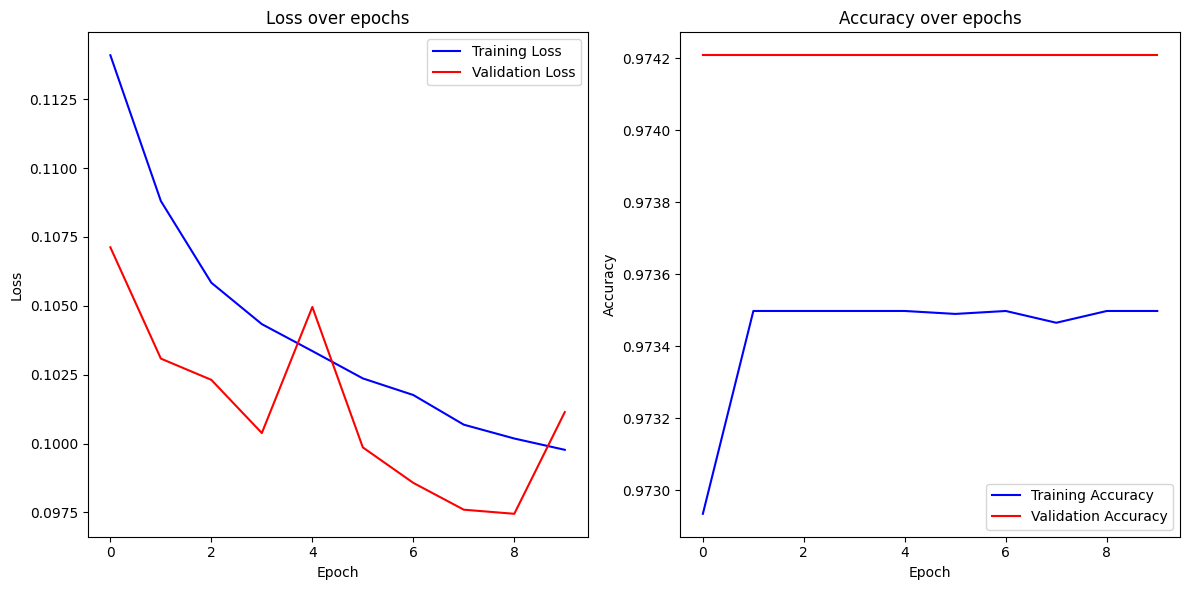

In [ ]:

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

In [155]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.9729 - loss: 0.1028
Test accuracy: 97.42%


In [ ]:
y_pred_prob = model.predict(X_test)



y_pred = (y_pred_prob > 0.5).astype(int)


f1 = f1_score(y_test, y_pred)

print(f'F1 Score: {f1}')

956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step
F1 Score: 0.9869360046361454


In [ ]:
dates = pd.date_range(start='2024-01-01', end='2024-02-28').strftime('%Y-%m-%d').tolist()



In [ ]:
import pandas as pd
from datetime import timedelta


def get_second_friday_of_august(year):
    august_1st = pd.to_datetime(f'{year}-08-01')
    first_friday = august_1st + timedelta(days=(4 - august_1st.weekday()) % 7)
    second_friday = first_friday + timedelta(weeks=1)
    return second_friday


def get_third_friday_of_december(year):
    december_1st = pd.to_datetime(f'{year}-12-01')
    first_friday = december_1st + timedelta(days=(4 - december_1st.weekday()) % 7)
    third_friday = first_friday + timedelta(weeks=2)
    return third_friday


def get_first_monday_of_january(year):
    january_1st = pd.to_datetime(f'{year+1}-01-01')
    first_monday = january_1st + timedelta(days=(7 - january_1st.weekday()) % 7)
    return first_monday


def check_vacation_or_weekend(date, vacation_ranges):
    date = pd.to_datetime(date)
    
    
    if date.weekday() >= 5:  
        return "weekend"
    
    
    for start, end in vacation_ranges:
        if start <= date <= end:
            return "vacation"
    
    return "working day"


def extract_date_features(date):
    
    date = pd.to_datetime(date)

    
    features = {
        'DayOfWeek': date.weekday(),  
        'DayOfMonth': date.day,
        'WeekOfMonth': (date.day - 1) // 7 + 1,  
        'Month': date.month
    }
    return features


def predict_absenteeism(date, model, vacation_ranges):
    
    year = pd.to_datetime(date).year
    
    
    status = check_vacation_or_weekend(date, vacation_ranges)
    
    if status != "working day":
        return status
    
    
    date_features = extract_date_features(date)
    date_features_df = pd.DataFrame([date_features])
    
    
    prediction = model.predict(date_features_df)  
    probability_present = prediction[0][0]  
    
    return f"Probability of being present on {date}: {probability_present:.4f}"


def get_vacation_ranges(date):
    year = pd.to_datetime(date).year
    
    
    summer_vacation_start = get_second_friday_of_august(year)
    summer_vacation_end = summer_vacation_start + timedelta(weeks=2)

    winter_vacation_start = get_third_friday_of_december(year)
    winter_vacation_end = get_first_monday_of_january(year)

    return [
        (summer_vacation_start, summer_vacation_end),
        (winter_vacation_start, winter_vacation_end)
    ]


chosen_date = dates
p=[]
for date in chosen_date:


    vacation_ranges = get_vacation_ranges(date)

    
    result = predict_absenteeism(date, model, vacation_ranges)
    print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Probability of being present on 2024-01-01: 0.5596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probability of being present on 2024-01-02: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Probability of being present on 2024-01-03: 0.9908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Probability of being present on 2024-01-04: 0.9981
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Probability of being present on 2024-01-05: 0.9964
weekend
weekend
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Probability of being present on 2024-01-08: 0.9052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Probability of being present on 2024-01-09: 0.9619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Probability of being present on 2024-01-10: 0.9792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probability of being present on 2024-01-11: 0.9874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Probability of being present on 2024-01-12: 0.9929
weekend
weekend
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of being present on 2024-01-1

I will save the cnn model

In [194]:
model.save('cnn_presence_model.keras')



In [198]:
loaded_model = load_model('cnn_presence_model.keras')

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**The CNN model was chosen over XGBoost as it provides more realistic and nuanced probabilities, capturing patterns and uncertainties better suited for the temporal nature of the absenteeism data.**

In [ ]:


def get_second_friday_of_august(year):
    august_1st = pd.to_datetime(f'{year}-08-01')
    first_friday = august_1st + timedelta(days=(4 - august_1st.weekday()) % 7)
    return first_friday + timedelta(weeks=1)

def get_third_friday_of_december(year):
    december_1st = pd.to_datetime(f'{year}-12-01')
    first_friday = december_1st + timedelta(days=(4 - december_1st.weekday()) % 7)
    return first_friday + timedelta(weeks=2)

def get_first_monday_of_january(year):
    january_1st = pd.to_datetime(f'{year+1}-01-01')
    return january_1st + timedelta(days=(7 - january_1st.weekday()) % 7)


def check_vacation_or_weekend(date, vacation_ranges):
    date = pd.to_datetime(date)
    if date.weekday() >= 5:  
        return "weekend"
    for start, end in vacation_ranges:
        if start <= date <= end:
            return "vacation"
    return "working day"


def extract_date_features(date):
    date = pd.to_datetime(date)
    return {
        'DayOfWeek': date.weekday(),
        'DayOfMonth': date.day,
        'WeekOfMonth': (date.day - 1) // 7 + 1,
        'Month': date.month
    }


def predict_absenteeism(date, model):
    date = pd.to_datetime(date)
    year = date.year

    
    vacation_ranges = [
        (get_second_friday_of_august(year), get_second_friday_of_august(year) + timedelta(weeks=2)),
        (get_third_friday_of_december(year), get_first_monday_of_january(year))
    ]

    
    status = check_vacation_or_weekend(date, vacation_ranges)
    if status != "working day":
        return status

    
    features = extract_date_features(date)
    features_df = pd.DataFrame([features])

    
    prediction = model.predict(features_df)
    probability_present = prediction[0][0]  

    return f" on {date.date()}: {(probability_present)*100:.2f}% of being present, {(1-probability_present)*100:.2f}% of being absent"






In [199]:
date=str(input())
print(predict_absenteeism(date, loaded_model))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
 on 2024-01-01: 55.96% of being present, 44.04% of being absent


In [10]:
import pandas as pd
from datetime import timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

loaded_model=load_model("cnn_presence_model.keras")
def get_second_friday_of_august(year):
    august_1st = pd.to_datetime(f'{year}-08-01')
    first_friday = august_1st + timedelta(days=(4 - august_1st.weekday()) % 7)
    return first_friday + timedelta(weeks=1)

def get_third_friday_of_december(year):
    december_1st = pd.to_datetime(f'{year}-12-01')
    first_friday = december_1st + timedelta(days=(4 - december_1st.weekday()) % 7)
    return first_friday + timedelta(weeks=2)

def get_first_monday_of_january(year):
    january_1st = pd.to_datetime(f'{year+1}-01-01')
    return january_1st + timedelta(days=(7 - january_1st.weekday()) % 7)


def check_vacation_or_weekend(date, vacation_ranges):
    date = pd.to_datetime(date)
    if date.weekday() >= 5:  
        return "weekend"
    for start, end in vacation_ranges:
        if start <= date <= end:
            return "vacation"
    return "working day"


def extract_date_features(date):
    date = pd.to_datetime(date)
    return {
        'DayOfWeek': date.weekday(),
        'DayOfMonth': date.day,
        'WeekOfMonth': (date.day - 1) // 7 + 1,
        'Month': date.month
    }


def predict_absenteeism(date, model):
    date = pd.to_datetime(date)
    year = date.year

    
    vacation_ranges = [
        (get_second_friday_of_august(year), get_second_friday_of_august(year) + timedelta(weeks=2)),
        (get_third_friday_of_december(year), get_first_monday_of_january(year))
    ]

    
    status = check_vacation_or_weekend(date, vacation_ranges)
    if status != "working day":
        return status

    
    features = extract_date_features(date)
    features_df = pd.DataFrame([features])

    
    prediction = model.predict(features_df)
    probability_present = prediction[0][0]  

    return f" on {date.date()}: {(probability_present)*100:.2f}% of being present, {(1-probability_present)*100:.2f}% of being absent"
while True:
    date=str(input())
    print(predict_absenteeism(date, loaded_model))


weekend
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
 on 2026-05-15: 99.34% of being present, 0.66% of being absent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 on 2014-02-06: 86.14% of being present, 13.86% of being absent


: 